In [70]:
# Import the libraries

import pandas as pd 
import numpy as np

from pprint import pprint

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

import spacy

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.corpus import wordnet

import warnings
warnings.filterwarnings("ignore")


Code references:

https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/


In [43]:
df = pd.read_csv('/Users/siriamanda/Desktop/LNU-VT-2021/Thesis/11-data-analysis/sentiment-analysis-of-reviews/01-sentiment-analysis/01-programming-for-everybody/VADER-programming-for-everybody.csv')

In [44]:
df.head()

,Unnamed: 0,date,review,rating,status,length,label,language_scores,language,scores,compound,sentiment
0,0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,135,pos,"{'language': 'en', 'score': 0.9999988169641919}",en,"{'neg': 0.0, 'neu': 0.601, 'pos': 0.399, 'comp...",0.9062,pos
1,1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,163,pos,"{'language': 'en', 'score': 0.9999984011655625}",en,"{'neg': 0.0, 'neu': 0.453, 'pos': 0.547, 'comp...",0.9678,pos
2,2,2021-03-11,Very interactive and a nice course to start pr...,5,completer,67,pos,"{'language': 'en', 'score': 0.9999980645444568}",en,"{'neg': 0.0, 'neu': 0.746, 'pos': 0.254, 'comp...",0.4703,pos
3,3,2021-03-11,Awesome course! Definitely a very nice introdu...,5,completer,166,pos,"{'language': 'en', 'score': 0.9999973332745635}",en,"{'neg': 0.0, 'neu': 0.553, 'pos': 0.447, 'comp...",0.9448,pos
4,4,2021-03-11,Perfect for new learners,5,completer,24,pos,"{'language': 'en', 'score': 0.9999967444537561}",en,"{'neg': 0.0, 'neu': 0.448, 'pos': 0.552, 'comp...",0.5719,pos


In [45]:
df.drop(['Unnamed: 0', 'language_scores', 'language', 'scores'], axis = 1, inplace = True)

In [46]:
df

,date,review,rating,status,length,label,compound,sentiment
0,2021-03-11,Nice Course for beginners where we can enjoy a...,5,completer,135,pos,0.9062,pos
1,2021-03-11,Super easy and totally for the beginners like ...,5,completer,163,pos,0.9678,pos
2,2021-03-11,Very interactive and a nice course to start pr...,5,completer,67,pos,0.4703,pos
3,2021-03-11,Awesome course! Definitely a very nice introdu...,5,completer,166,pos,0.9448,pos
4,2021-03-11,Perfect for new learners,5,completer,24,pos,0.5719,pos
...,...,...,...,...,...,...,...,...
9558,2020-07-21,excellent explanation starting with how comput...,5,dropout,129,pos,0.9080,pos
9559,2020-07-21,My friend recommanded the lecture. It really d...,5,dropout,69,pos,0.5411,pos
9560,2020-07-21,Highly recommend this sets a good foundation ...,5,dropout,56,pos,0.6901,pos
9561,2020-07-21,best python programming course for absolute be...,5,dropout,53,pos,0.6369,pos


In [47]:
# Check for null values

len(df[df['review'].isna()==True])

0

In [48]:
# Drop null values

# df.dropna(inplace = True)

In [49]:
# Check for null values

# len(df[df['review'].isna()==True])

In [50]:
# Reset the index

# df = df.reset_index(drop = True)

In [51]:
# df

In [52]:
# Define a function to plot the most frequent words

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.xticks(rotation = 45)
    plt.show()

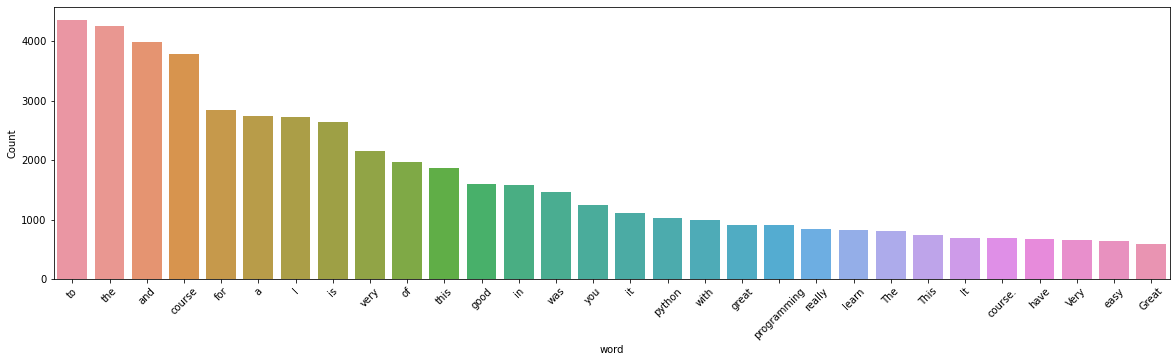

In [53]:
# The most frquent words are stop words such as 'to' and 'the' we will remove these in the preprocessing steps

freq_words(df['review'])

## Preprocessing

In [114]:
# Covert to lowercase

df['preprocessed'] =  df['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['preprocessed'].head()

0    nice course for beginners where we can enjoy a...
1    super easy and totally for the beginners like ...
2    very interactive and a nice course to start pr...
3    awesome course! definitely a very nice introdu...
4                             perfect for new learners
Name: preprocessed, dtype: object

In [115]:
# Remove punctuations

df['preprocessed'] = df['preprocessed'].str.replace('[^\w\s]','')
df['preprocessed'].head()

0    nice course for beginners where we can enjoy a...
1    super easy and totally for the beginners like ...
2    very interactive and a nice course to start pr...
3    awesome course definitely a very nice introduc...
4                             perfect for new learners
Name: preprocessed, dtype: object

In [116]:
# Remove stopwords

stop = stopwords.words('english')
stop.extend(['good', 'great', 'really', 'like', 'nice'])

df['preprocessed'] = df['preprocessed'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['preprocessed'].head()

0    course beginners enjoy learn well dr chuck mad...
1    super easy totally beginners course title prof...
2          interactive course start programming pyhton
3    awesome course definitely introduction coding ...
4                                 perfect new learners
Name: preprocessed, dtype: object

In [117]:
# Build a model for creating bigrams

# bigram = gensim.models.Phrases(texts)

# df['preprocessed'] = [bigram[line] for line in df['preprocessed']]
# df['preprocessed'].head(5)

In [118]:
# Check for null values

# len(df[df['preprocessed'].isna()==True])

In [119]:
# Remove short words (length < 3)

# df['review'] = df['review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
# df['review'].head()

In [120]:
# Join reviews

# df['joined'] = df['preprocessed'].apply(lambda x: ' '.join(x))

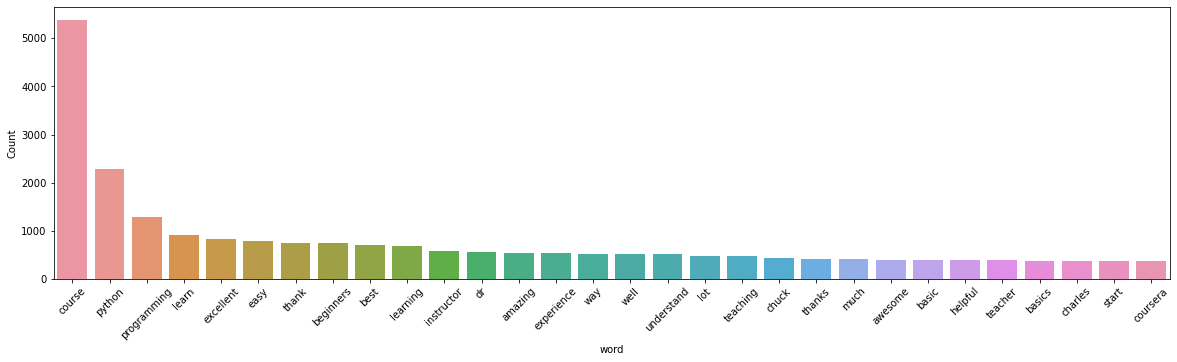

In [121]:
# Look at the most frequent words again 

freq_words(df['preprocessed'])

In [122]:
# Tokenization

tokenizer = RegexpTokenizer(r'\w+')

df['preprocessed'] = df['preprocessed'].apply(lambda x: tokenizer.tokenize(x.lower()))
df['preprocessed'].head(5)


0    [course, beginners, enjoy, learn, well, dr, ch...
1    [super, easy, totally, beginners, course, titl...
2    [interactive, course, start, programming, pyhton]
3    [awesome, course, definitely, introduction, co...
4                             [perfect, new, learners]
Name: preprocessed, dtype: object

In [123]:
# Add speech tags

df['preprocessed'] = df['preprocessed'].apply(nltk.tag.pos_tag)
df['preprocessed'].head()

0    [(course, NN), (beginners, NNS), (enjoy, VBP),...
1    [(super, JJ), (easy, JJ), (totally, RB), (begi...
2    [(interactive, JJ), (course, NN), (start, NN),...
3    [(awesome, JJ), (course, NN), (definitely, RB)...
4          [(perfect, JJ), (new, JJ), (learners, NNS)]
Name: preprocessed, dtype: object

In [124]:
# Define function to convert parts of speech tags to wordnet’s format

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [125]:
# Apply the function to the tagged data

df['preprocessed'] = df['preprocessed'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
df['preprocessed'].head()

0    [(course, n), (beginners, n), (enjoy, v), (lea...
1    [(super, a), (easy, a), (totally, r), (beginne...
2    [(interactive, a), (course, n), (start, n), (p...
3    [(awesome, a), (course, n), (definitely, r), (...
4              [(perfect, a), (new, a), (learners, n)]
Name: preprocessed, dtype: object

In [126]:
# Create lemmatizer

lemmatizer = WordNetLemmatizer()

# Apply to data 

df['preprocessed'] = df['preprocessed'].apply(lambda x: [lemmatizer.lemmatize(word, tag) for word, tag in x])
df['preprocessed'].head()

0    [course, beginner, enjoy, learn, well, dr, chu...
1    [super, easy, totally, beginner, course, title...
2        [interactive, course, start, program, pyhton]
3    [awesome, course, definitely, introduction, co...
4                              [perfect, new, learner]
Name: preprocessed, dtype: object

In [127]:
# Join reviews

df['joined'] = df['preprocessed'].apply(lambda x: ' '.join(x))

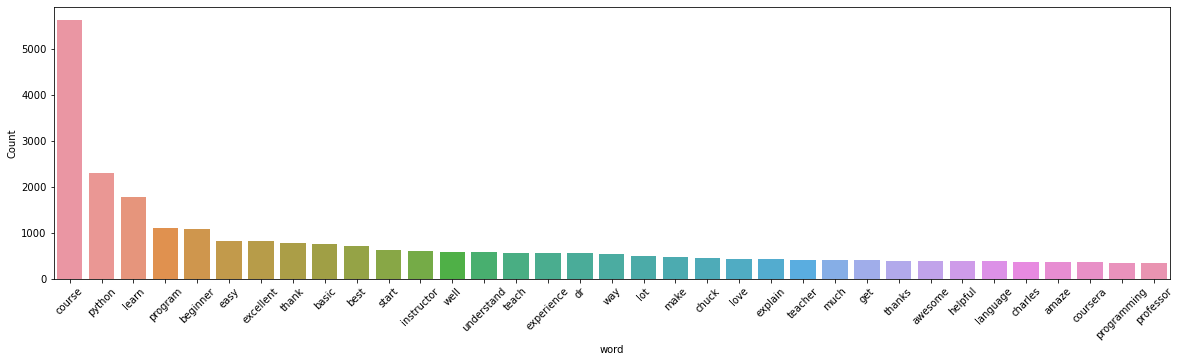

In [128]:
# Most frequent words after lemmatizing 

freq_words(df['joined'], 35)

## LDA Topic Modeling

In [129]:
# Create a dictionary from 'df_sen['review']' containing the number of times a word appears in the training set

dictionary = gensim.corpora.Dictionary(df['preprocessed'])

In [130]:
# Gensim filter extremes

# Filter out tokens that appear in:
# Less than 50 documents, more than 0.5 documents, and keep only 100000 most frquent tokens

# dictionary.filter_extremes(no_below = 50, no_above = 0.5, keep_n = 100000)

In [131]:
# Gensim doc2bow
# Create a dictionary reporting how many words and how many times those words appear

corpus = [dictionary.doc2bow(doc) for doc in df['preprocessed']]


In [132]:
# Add TF-IDF

tfidf = models.TfidfModel(corpus)      # Create a TF-IDF model
corpus_tfidf = tfidf[corpus]  

In [133]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.LdaMulticore

# Build LDA model
lda_model = LDA(corpus = corpus, id2word = dictionary, num_topics = 5, random_state = 100,
                chunksize = 100, passes = 10)

In [134]:
# Explore the words occurring in each topic and its relative weight

for id, topic in lda_model.print_topics(-1):
    print('Topic: {}\nWord: {}\n'.format(id, topic))

Topic: 0
Word: 0.026*"course" + 0.014*"program" + 0.013*"assignment" + 0.013*"would" + 0.013*"helpful" + 0.011*"make" + 0.010*"python" + 0.009*"learn" + 0.008*"go" + 0.008*"take"

Topic: 1
Word: 0.201*"course" + 0.063*"beginner" + 0.054*"best" + 0.025*"python" + 0.025*"well" + 0.021*"instructor" + 0.021*"one" + 0.013*"ever" + 0.013*"wonderful" + 0.012*"amazing"

Topic: 2
Word: 0.111*"python" + 0.084*"course" + 0.056*"learn" + 0.051*"program" + 0.051*"basic" + 0.034*"start" + 0.024*"language" + 0.021*"programming" + 0.020*"useful" + 0.017*"knowledge"

Topic: 3
Word: 0.081*"awesome" + 0.060*"experience" + 0.027*"learn" + 0.018*"enjoy" + 0.016*"learning" + 0.015*"fun" + 0.013*"perfect" + 0.011*"interactive" + 0.009*"fantastic" + 0.009*"content"

Topic: 4
Word: 0.066*"course" + 0.045*"excellent" + 0.040*"thank" + 0.033*"easy" + 0.028*"learn" + 0.027*"dr" + 0.023*"teach" + 0.021*"chuck" + 0.020*"thanks" + 0.020*"teacher"



### Visualise with pyLDAvis

Original paper: https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

In [135]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.057116 -0.067677       1        1  26.791385
4     -0.042196  0.190203       2        1  26.347239
2     -0.130938 -0.201816       3        1  21.687402
1     -0.101938  0.111958       4        1  17.993460
3      0.332188 -0.032669       5        1   7.180515, topic_info=           Term         Freq        Total Category  logprob  loglift
4        course  5148.000000  5148.000000  Default  30.0000  30.0000
12       python  2115.000000  2115.000000  Default  29.0000  29.0000
0         basic   722.000000   722.000000  Default  28.0000  28.0000
70         best   641.000000   641.000000  Default  27.0000  27.0000
1      beginner   992.000000   992.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
248  assignment    29.104065   263.259951   Topic5  -5.0820   0.4315
112         lot    31.485769   466.400105   Topic5  -5.0034  -0.0617
35         much    22.105759   361.853196   Topic5  -5.3571  -0.1616
188       video    18.234123   173.737921   Topic5  -5.5496   0.3795
71        class    18.497165   260.102795   Topic5  -5.5353  -0.0097

[328 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
247       3  0.972648         7
383       1  0.042452  absolute
383       4  0.933937  absolute
800       3  0.959793   advance
718       2  0.975210      alot
...     ...       ...       ...
239       4  0.080797     would
416       1  0.993937     write
2505      1  0.961666      year
74        1  0.059827      zero
74        3  0.917344      zero

[514 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 2, 4])

What is topic perplexity and topic coherence: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [136]:
# Calculate Perplexity and Coherence

# Compute Perplexity

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model = lda_model, texts = df['preprocessed'], dictionary = dictionary, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.39270446296514

Coherence Score:  0.5373231671418205


## Hyperparameter Tuning

Code references

Find the optimal number of topics, alpha and beta: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

What is alpha and beta: https://www.thoughtvector.io/blog/lda-alpha-and-beta-parameters-the-intuition/

## Calculate the coherence score

Code reference: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [137]:
# Determine the optiomal number of topics by calculating the coherence score

# Define function for calculating coherence score

def compute_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LDA(corpus = corpus, num_topics = num_topics, id2word = dictionary, random_state = 100,
                chunksize = 100, passes = 10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [138]:
# Can take a long time to run.

model_list, coherence_values = compute_coherence_values(dictionary = dictionary, corpus = corpus, texts = df['preprocessed'], start = 2, limit = 10, step = 1)

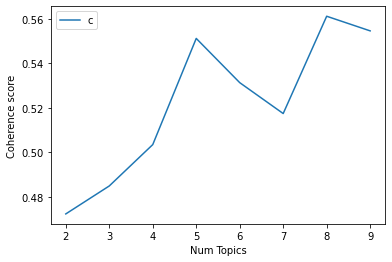

In [139]:
# Show graph

limit = 10; start = 2; step = 1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()


In [140]:
# Print the coherence scores

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4724
Num Topics = 3  has Coherence Value of 0.4849
Num Topics = 4  has Coherence Value of 0.5035
Num Topics = 5  has Coherence Value of 0.5512
Num Topics = 6  has Coherence Value of 0.5313
Num Topics = 7  has Coherence Value of 0.5174
Num Topics = 8  has Coherence Value of 0.5611
Num Topics = 9  has Coherence Value of 0.5546


## LDA Mallet Model

Code reference:

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [141]:
mallet_path = '/Users/siriamanda/Desktop/LNU-VT-2021/Thesis/11-data-analysis/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics = 5, id2word = dictionary)

In [142]:
# Show Topics
pprint(ldamallet.show_topics(formatted = False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model = ldamallet, texts = df['preprocessed'], dictionary = dictionary, coherence = 'c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

# The coherence score using the Mallet Model is lower than the original LDA Model

[(0,
  [('python', 0.17656974294142436),
   ('program', 0.11651917404129794),
   ('basic', 0.08101559207753899),
   ('start', 0.06552886641382216),
   ('language', 0.04003371260008428),
   ('programming', 0.037399915718499786),
   ('knowledge', 0.03350189633375474),
   ('recommend', 0.021175726927939318),
   ('introduction', 0.02054361567635904),
   ('cod', 0.019068689422671724)]),
 (1,
  [('beginner', 0.10006469700237222),
   ('excellent', 0.08841923657537201),
   ('instructor', 0.06372654733664007),
   ('teach', 0.06027604054345482),
   ('love', 0.047013155057149016),
   ('awesome', 0.04259219322838042),
   ('charles', 0.040759111494500753),
   ('helpful', 0.04011214147077852),
   ('professor', 0.03472072460642657),
   ('clear', 0.025231830925167134)]),
 (2,
  [('learn', 0.18237115682371158),
   ('python', 0.06801592568015925),
   ('experience', 0.0617120106171201),
   ('lot', 0.05596107055961071),
   ('coursera', 0.040145985401459854),
   ('enjoy', 0.028422915284229154),
   ('intere